# IIR nmigen to Vivado

Let's start with the Vivado environment. <br>
At first a Stimulusfile is created, which makes a jump from 0x000000 to 0x00ffff after 1us. <br>
The Stimulusfile also creates different frequencys an is able to generate a sine oder other defined signals, but here only the jump should be used.<br>
The Stimulusfile also generates the needed signals for the resets. <br>
It's written in vhdl.


The Testbench with differen filters looks somehow like this:

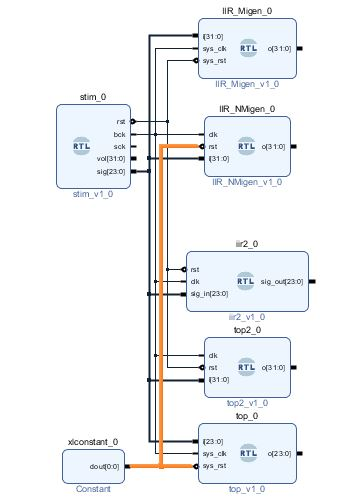

In [33]:
from IPython.display import Image
Image("img/VivadoTB.JPG")

# Given Filters 

To demonstrate how a working Filter should look like, I used a FIR and an IIR Filter (fcutoff = 1kHz). <br>
The FIR Filter was generated with the first example from the Notebook "FIR to IIR" <br>
The IIR Filter was given from a Prof. form the Munich University of Applied Sciences.

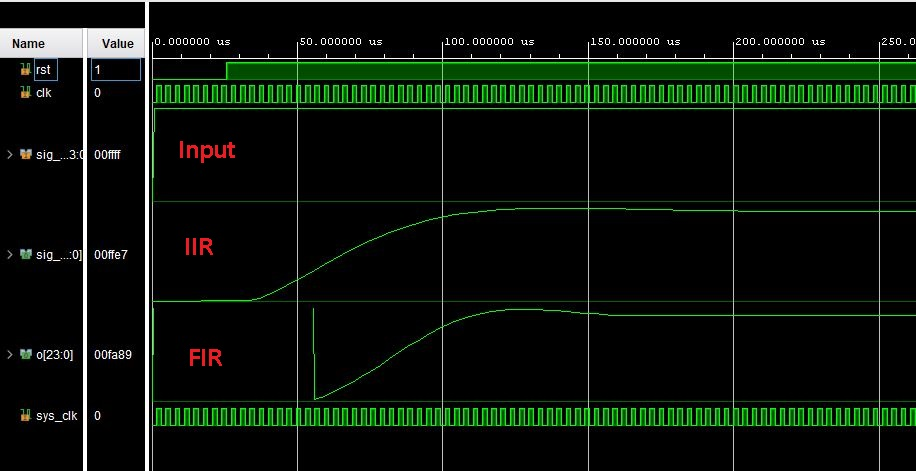

In [18]:
from IPython.display import Image
Image("img/VivadoSim1.JPG")


# Python to Verilog Software

Vivado can work with Verilog or VHDL code. <br>
The whole filter design was written within python with migen and nmigen. <br>
Migen has a built-in translator, which is kind of buggy, therefore the switch to nmigen was made. <br>
Nmigen uses Yosys as their translator which is a stand-alone software, which must be installed at your PC. <br>
I use Windows, so I downloaded Yosys from here: http://www.clifford.at/yosys/download.html <br>
To use Yosys, you have to make it accessible for Windows. Type in your Google search: "windows path variable". <br>
Follow the steps and add a path variable with the location, where you have installed Yosys on your PC. <br>
If you have installed Python on your PC, you should have the Console "Anaconda Prompt". I use Version 1.7.2 <br>

# Some more Python

In order to generate with Yosys some Verilog code, an additional line of code is necessary. <br>
main(IIR,ports=(IIR.i,IIR.o)) <br>
The additional line is needed because Yosys needs to generate some input and output ports. <br>

The whole code looks now like this:

coefa:
[ 1.         -1.81534108  0.83100559]
coefb:
[0.00391613 0.00783225 0.00391613]
Expmin = 
 8
None
Expmax = 
 14
None
[ 1.         -1.81534108  0.83100559] [0.00391613 0.00783225 0.00391613]
[ 16384 -29742  13615]
[ 64 128  64]


<ipython-input-19-b66d0311a301>:134: DeprecationWarning: instead of `with Simulator(fragment, ...) as sim:`, use `sim = Simulator(fragment); with sim.write_vcd(...):`
  with Simulator(IIR) as sim:


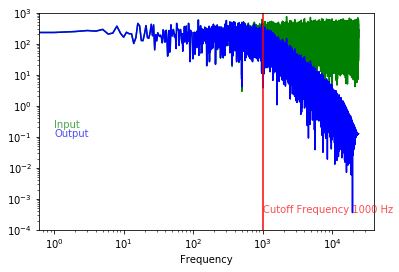

usage: ipykernel_launcher.py [-h] {generate,simulate} ...
ipykernel_launcher.py: error: argument action: invalid choice: 'C:\\Users\\Berni\\AppData\\Roaming\\jupyter\\runtime\\kernel-9c554bdd-6cc9-4c0a-bc9a-aba5063071c8.json' (choose from 'generate', 'simulate')
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "c:\users\berni\anaconda3\lib\argparse.py", line 1800, in parse_known_args
    namespace, args = self._parse_known_args(args, namespace)
  File "c:\users\berni\anaconda3\lib\argparse.py", line 2009, in _parse_known_args
    stop_index = consume_positionals(start_index)
  File "c:\users\berni\anaconda3\lib\argparse.py", line 1965, in consume_positionals
    take_action(action, args)
  File "c:\users\berni\anaconda3\lib\argparse.py", line 1858, in take_action
    argument_values = self._get_values(action, argument_strings)
  File "c:\users\berni\anaconda3\lib\argparse.py", line 2399, in _get_values
    self._check_value(action, value[0])
  File "c:\users\berni\anaconda3\lib\argparse.py", line 2446, in _check_value
    raise ArgumentError(action, msg % args)
argparse.ArgumentError: argument action: invalid choice: 'C:\\Users\\Berni\\AppData\\Roaming\\jupyter\\runtime\\kernel-9c554bdd-6cc9-4c0a-bc9a-aba5063071c8.json' (choose from 'generate', 'simu

SystemExit: 2

c:\users\berni\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3339: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [19]:
from scipy import signal
from nmigen import *
from nmigen.back.pysim import *
from nmigen.cli import main
import matplotlib.pyplot as plt
import numpy as np
import wave, struct
from scipy.signal import chirp
import numpy

from functools import reduce
from operator import add

from math import cos, pi
from nmigen.compat import *
from nmigen import *
from nmigen.cli import main
from nmigen.back.pysim import *
import math

#from nmigen_boards.icebreaker import *

### Create the filter #######################
Fs = 48000           #Sample Frequ
samples = 48000       #Number of Samples
dt = 1/Fs
n = 2               #Order of Filter
fc = 1000            #Cut Frequ
w_c = 2*fc/Fs       #Digital Frequ -> 0 - 0.5
Type = "int16"      #Type of the internal calc
wsize = 16         #Wordlength
#########################################################

### Noise Source##################################
mean = 0        #  is the mean of the normal distribution you are choosing from
std = 1         #  is the standard deviation of the normal distribution
################################################

### Find the smallest possible Exponent out of coefa and coefb ###########
def minExp (lista,listb,maxsize):
    if maxsize == "int16":
        maxsize = 16
    elif maxsize == "int32":
        maxsize = 32
    elif maxsize == "int64":
        maxsize = 64
    else:
        raise TypeError("The Exponent must be an Integer")
    lista =  [abs(ele) for ele in lista]                            #Generates a List of absolute Values
    listb =  [abs(ele) for ele in listb]                            #Generates a List of absolute Values
    minall = min(min(lista), min(listb))                            #find the minimum of the two new lists
    maxall = max(max(lista), max(listb))                            #find the maximum of the two new lists
    Expmin = int(round(0.49 + math.log(1/minall, 2)))               #find the minimum Exponent
    Expmax = int(round(math.log((2**(maxsize-1))/maxall, 2)))       #find the maximum Exponent
    print(print("Expmin = \n", Expmin))
    print(print("Expmax = \n", Expmax))
    if Expmin > Expmax:
        raise OverflowError("Filter is not possible, enlarge the internal Register or define the specs in another way")
    return Expmin,Expmax                                            #return this two found Exponents
#########################################################################

### Used to do test for the needed Exponent##############################
def Multiplyer (coefa,coefb,Exponent):
    print(coefa,coefb)
    for c in range(len(coefa)):
        coefa[c] = np.int(coefa[c]*2**Exponent)        #Takes the Coeficients an multiplys it with 2**Exp then cuts the fract bits
    coefa = coefa.astype(Type)
    print(coefa)
    for c in range(len(coefb)):
        coefb[c] = int(coefb[c]*2**Exponent)        #Takes the Coeficients an multiplys it with 2**Exp then cuts the fract bits
    coefb = coefb.astype(Type)
    print(coefb)
    return coefa,coefb
########################################################################


class iir(Elaboratable):
    def __init__(self, num,den, Exponent=16, wsize=32):     #num = coefa den = coefb
        num[0] = 0
        self.coefa = num
        self.coefb = den
        self.wsize = wsize
        self.i = Signal(signed(self.wsize*2))
        self.o = Signal(signed(self.wsize*2))
        self.Exponent = Exponent

        ###


    def elaborate(self, platform):
        m = Module()

        x_sigs = []
        for i in range(len(self.coefb)):
            x_sigs.append(Signal(signed(self.wsize*2)))

        m.d.comb += x_sigs[0].eq(self.i)

        for i in range(1, len(self.coefb)):
            m.d.sync += x_sigs[i].eq(x_sigs[i-1])

        y_sigs = []
        for i in range(len(self.coefa)):
            y_sigs.append(Signal(signed(self.wsize*2)))

        m.d.comb += y_sigs[0].eq(self.o)

        for i in range(1, len(self.coefa)):
            m.d.sync += y_sigs[i].eq(y_sigs[i-1])

        outputSum = 0
        for i in range(len(self.coefb)):
            outputSum += x_sigs[i]*int(self.coefb[i])
        for i in range(1, len(self.coefa)):
            outputSum -= y_sigs[i]*int(self.coefa[i])

        buf = Signal(signed(self.wsize*2))
        m.d.comb += buf.eq(outputSum)

        m.d.comb += self.o.eq(outputSum>>int(self.Exponent))

        return m
if __name__ == "__main__":
    [coefb,coefa] = signal.iirfilter(n,w_c ,0, btype="lowpass", analog=False, ftype="butter")
    #[w,h] = signal.freqz(coefb,coefa,int(Fs/2))
    print("coefa:")
    print(coefa)
    print("coefb:")
    print(coefb)
    Expmin,Expmax = minExp(coefa,coefb,Type)
    [coefa,coefb] = Multiplyer(coefa,coefb,Expmax)
    IIR = iir(coefa,coefb,Expmax,wsize)

    with Simulator(IIR) as sim:
    #sim = Simulator(crossover)
        def process():
            f = 2**wsize
            input = numpy.random.normal(mean, std, size=samples)
            #input = chirp(t=numpy.linspace(0, 1, samples), f0=1, f1=1000, t1=1, method='logarithmic',phi = 90)
            #plt.plot(input)
            output = []
            for i in input:
                yield IIR.i.eq(int(i*f))
                yield Tick()
                output.append((yield IIR.o)/f)
            #plt.plot(output)
            y = int(len(output)/2)
            H = np.fft.fft(output)
            H_half = H[:y]
            N = np.fft.fft(input)
            N_half = N[:y]

            fig = plt.figure()
            ax = fig.add_subplot(111)
            #ax.plot(h)
            ax.plot(np.abs(N_half),color = 'g')
            ax.plot(np.abs(H_half),color = 'b')
            ax.set_yscale('log')
            ax.set_xscale('log')
            ax.set_xlabel('Frequency')
            ax.set_ylim(0.0001,1000)
            ax.axvline(fc,color='r')
            ax.text(x=fc, y=min(np.abs(H_half)), s='Cutoff Frequency ' + str(fc) + ' Hz', alpha=0.7, color='r')
            ax.text(x=1, y=0.2, s='Input', alpha=0.7, color='g')
            ax.text(x=1, y=0.1, s='Output', alpha=0.7, color='b')
            plt.show()

        sim.add_clock(1e-9)
        sim.add_sync_process(process)
        sim.run()
        main(IIR,ports=(IIR.i,IIR.o))

I have no idea why here are problems occurring. If I run this script with Anaconda on my Computer, nothing occurs. <br>
So let's behave like everything is fine and ignore all these exceptions.

# Python to Verilog code conversion

In the last step, the Filter which should be used was generated and simulated via Python. <br>
Start Anaconda Prompt. <br>
Navigate to the location of the Python file. <br>



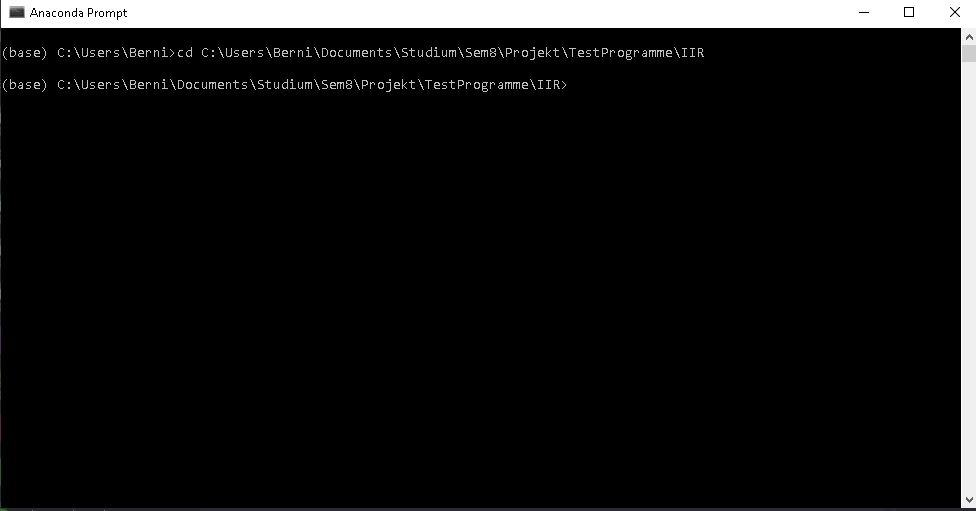

In [20]:
from IPython.display import Image
Image("img/Anaconda1.JPG")

  Run to following comand to translate the filter into verilog.  

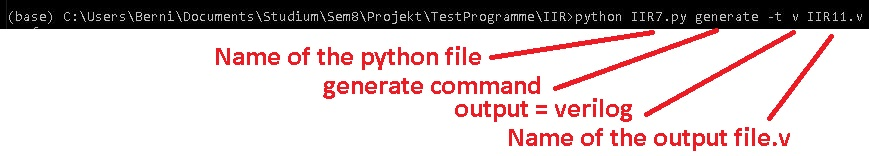

In [23]:
from IPython.display import Image
Image("img/Anaconda2.JPG")

The File which is generated should look like this:

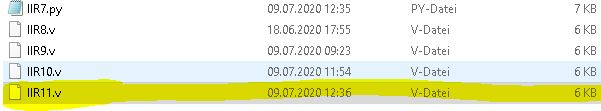

In [24]:
from IPython.display import Image
Image("img/Anaconda3.JPG")

# Add a new source

Open Vivado, start the project with the Testbench from above, and add a new source to the project.

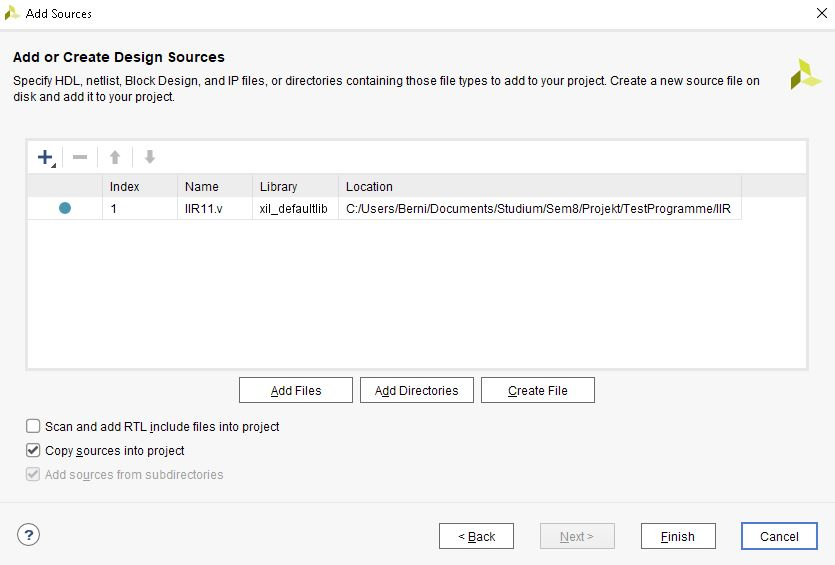

In [26]:
from IPython.display import Image
Image("img/VivadoSim3.JPG")

Open the verilogfile and delete the following first rows: <br>
(* generator = "nMigen" *) <br>
(* top =  1  *) <br>
(* \nmigen.hierarchy  = "top" *) <br>
By the way, every linke which looks like this (* src = "IIR7.py:113" *) or like this (* src = "C:\\Users\\Berni\\Anaconda3\\lib\\site-packages\\nmigen\\hdl\\xfrm.py:530" *)  could possibly be deleted. <br>



Then lets edit the Module name: <br>
module top(o, clk, rst, i); <br>
Change the Word "top" to the name the filter should have. <br>
The result should look like this:

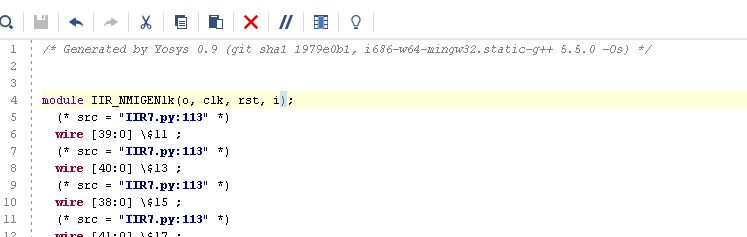

In [27]:
from IPython.display import Image
Image("img/VivadoSim5.JPG")

The cleared file should look like:

Insert the Filter into the blockdesign:


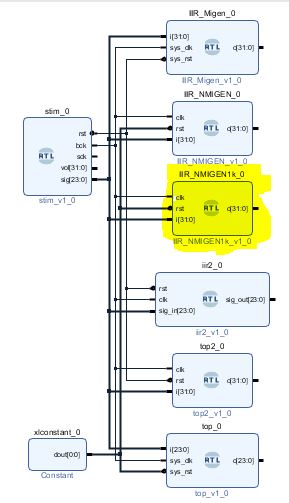

In [28]:
from IPython.display import Image
Image("img/VivadoSim4.JPG")

**Connect the rst pin of the Filter with a constant with the value 0 or change the Verilogfile!!!!!!!**

# Result

Start the Simulation again and display the output of the Filter. <br>
There are some warnings from Vivado that only the lower 24 bits are connected, which is totally fine because the test signal only needs the lower 16 bit. <br>

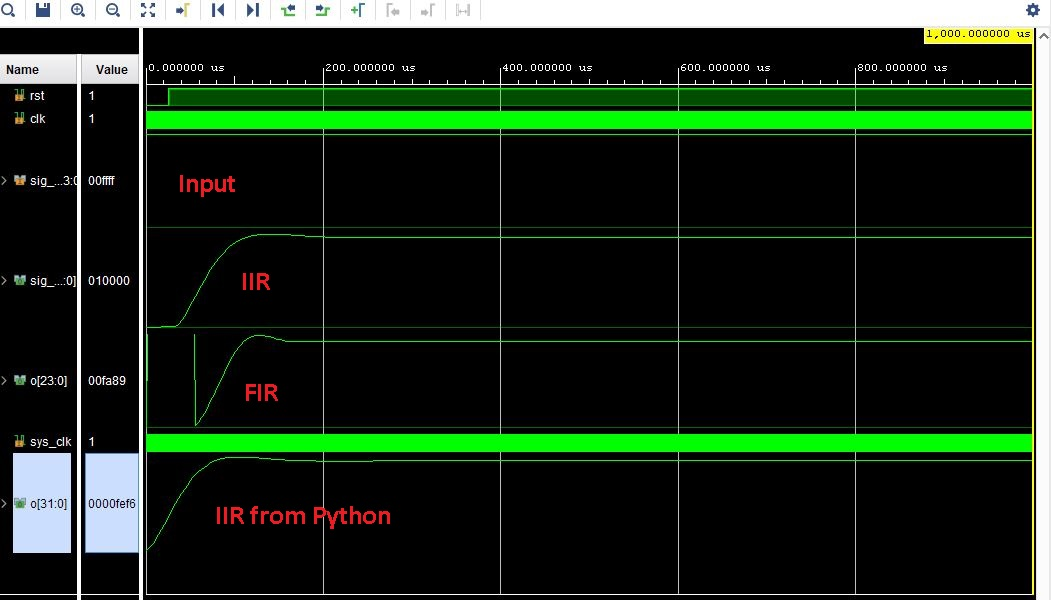

In [32]:
from IPython.display import Image
Image("img/VivadoSim2.JPG")